In [1]:
! pip install datasets --quiet
! pip install evaluate --quiet
! pip install transformers --quiet
!pip install huggingface_hub --quiet

!pip install accelerate -U --quiet
!pip install transformers[torch] --quiet
!pip install shap --quiet

### Generate Labels for Data

In [2]:
# create metadata (labels) to create the dataset object

import os
import csv

directory = "/content/drive/MyDrive/deceptive-16khz/"
data = []

for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        label = filename.split("_")[1]
        label = 1 if label == 'lie' else 0
        data.append((filename, label))

csv_file_path = "/content/drive/MyDrive/deceptive-16khz/metadata.csv"


with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["file_name", "label"])
    writer.writerows(data)

print(f"Metadata file created at {csv_file_path}")


Metadata file created at /content/drive/MyDrive/deceptive-16khz/metadata.csv


### Split data into sliding windows

In [2]:
# Windowing function
def window_audio(audio_array, window_size=10, overlap=0.75):
    sr = 16000
    window_size_samples = int(window_size * sr)
    overlap_samples = int(window_size_samples * overlap)

    windows = []
    for i in range(0, len(audio_array) - window_size_samples, overlap_samples):
        window = audio_array[i:i + window_size_samples]
        windows.append(window)

    return windows


In [3]:
def extract_mel_spectrogram(audio_array, sampling_rate=16000, n_mels=128):
    if not isinstance(audio_array, np.ndarray):
        audio_array = np.array(audio_array)

    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio_array, sr=sampling_rate, n_mels=n_mels, fmax=sampling_rate // 2
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

In [4]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000*10, truncation=True)
    return inputs

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)

    # Calculate precision, recall, and f1 score
    precision = precision_score(y_true=eval_pred.label_ids, y_pred=predictions, average='weighted')
    recall = recall_score(y_true=eval_pred.label_ids, y_pred=predictions, average='weighted')
    f1 = f1_score(y_true=eval_pred.label_ids, y_pred=predictions, average='weighted')

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1}

In [70]:
def apply_window(dataset):
   # apply windowing to the dataset
    windowed_dataset = defaultdict(list)
    for example in dataset:
      audio_array = example["audio"]["array"]
      windows = window_audio(audio_array)

      for window in windows:
        windowed_dataset["audio"].append({"array": window})
        windowed_dataset["label"].append(example["label"])


    dataset = DT.from_dict(windowed_dataset)
    return dataset


### Training


In [71]:
from datasets import load_dataset
from datasets import Audio
from datasets import DatasetDict
from datasets import Dataset as DT
from transformers import AutoFeatureExtractor
import evaluate
import numpy as np
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score,confusion_matrix,precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from collections import defaultdict
from transformers import EarlyStoppingCallback

def train_model(dataset):
  for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
      print(f"\n----- Fold {fold + 1} -----")


      # Create datasets for this fold
      train_dataset = dataset.select(train_idx)
      test_dataset = dataset.select(test_idx)
      print(train_dataset)
      print(test_dataset)
      train_dataset = apply_window(train_dataset)
      test_dataset = apply_window(test_dataset)
      print(train_dataset)
      print(test_dataset)
      # Preprocess the datasets
      encoded_train_dataset = train_dataset.map(preprocess_function, remove_columns="audio", batched=True)
      encoded_test_dataset = test_dataset.map(preprocess_function, remove_columns="audio", batched=True)

      # Model initialization
      num_labels = 2
      model = AutoModelForAudioClassification.from_pretrained(
         "facebook/hubert-base-ls960", num_labels=num_labels
      )

      training_args = TrainingArguments(
          output_dir= "hubert_deception-1",
          evaluation_strategy="epoch",
          save_strategy="epoch",
          learning_rate=3e-5,
          per_device_train_batch_size=8,
          gradient_accumulation_steps=4,
          per_device_eval_batch_size=8,
          num_train_epochs=10,
          warmup_ratio=0.1,
          logging_steps=10,
          load_best_model_at_end=True,
          push_to_hub=False,
        )

      feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")

      trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded_train_dataset,
        eval_dataset=encoded_test_dataset,
        tokenizer=feature_extractor,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(3, 0.0)]
    )

      trainer.train()

      eval_results = trainer.evaluate()

      # Print F1 score for this fold
      print(f"Fold {fold + 1} - F1 Score: {eval_results['eval_f1_score']}")
         # Append F1 score and confusion matrix to lists
      all_f1_scores.append(eval_results['eval_f1_score'])

  # Calculate mean F1 score
  mean_f1_score = np.mean(all_f1_scores)
  print(f"\nMean F1 Score across all folds: {mean_f1_score}")



In [72]:
#read data
dataset = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/deceptive-16khz",split='train')
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
print(dataset)

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
num_labels = 2
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_f1_scores = []
validation_indices = list(range(15)) + list(range(len(dataset['label']) - 25, 15))
validation_dataset = dataset.select(validation_indices)
dataset = dataset.select([i for i in range(len(dataset)) if i not in validation_indices])

train_model(dataset)

Resolving data files:   0%|          | 0/117 [00:00<?, ?it/s]

Dataset({
    features: ['audio', 'label'],
    num_rows: 115
})

----- Fold 1 -----
Dataset({
    features: ['audio', 'label'],
    num_rows: 80
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 20
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 233
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 61
})


Map:   0%|          | 0/233 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight', 'projector.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
0,No log,0.717638,0.181672,0.426230,0.254758
2,0.614900,0.839377,0.181672,0.426230,0.254758
4,0.563300,1.110801,0.181672,0.426230,0.254758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1 - F1 Score: 0.2547578669681552

----- Fold 2 -----
Dataset({
    features: ['audio', 'label'],
    num_rows: 80
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 20
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 233
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 61
})


Map:   0%|          | 0/233 [00:00<?, ? examples/s]

Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight', 'projector.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
0,No log,0.685700,0.310669,0.557377,0.398965
2,0.638800,0.655333,0.310669,0.557377,0.398965
4,0.619800,0.469119,0.825309,0.819672,0.816647
6,0.404800,0.352248,0.836066,0.836066,0.836066
8,0.346800,0.353305,0.836066,0.836066,0.836066
9,0.280500,0.359498,0.836066,0.836066,0.836066


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Fold 2 - F1 Score: 0.8855546293723566

----- Fold 3 -----
Dataset({
    features: ['audio', 'label'],
    num_rows: 80
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 20
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 234
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 60
})


Map:   0%|          | 0/234 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight', 'projector.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
0,No log,0.697986,0.202500,0.450000,0.279310
2,0.636200,0.711800,0.202500,0.450000,0.279310
4,0.539200,0.490370,0.835929,0.833333,0.833705
6,0.334400,0.438557,0.855000,0.850000,0.850376
8,0.295600,0.550308,0.869737,0.816667,0.813846
9,0.271400,0.506490,0.887500,0.850000,0.848872


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 - F1 Score: 0.8503759398496241

----- Fold 4 -----
Dataset({
    features: ['audio', 'label'],
    num_rows: 80
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 20
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 235
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 59
})


Map:   0%|          | 0/235 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight', 'projector.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
0,No log,0.696307,0.968220,0.491525,0.625053
2,0.656000,0.622072,0.970339,0.762712,0.838380
4,0.501100,0.211877,0.979661,0.949153,0.959361
6,0.254300,0.216739,0.979661,0.949153,0.959361
8,0.219100,0.176328,0.979661,0.949153,0.959361
9,0.177700,0.193887,0.979661,0.949153,0.959361


Fold 4 - F1 Score: 0.9593612983443492

----- Fold 5 -----
Dataset({
    features: ['audio', 'label'],
    num_rows: 80
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 20
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 241
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 53
})


Map:   0%|          | 0/241 [00:00<?, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight', 'projector.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
0,No log,0.681453,0.411534,0.641509,0.501410
1,0.686500,0.644484,0.411534,0.641509,0.501410
2,0.661000,0.561780,0.411534,0.641509,0.501410
4,0.539600,0.407938,0.876712,0.849057,0.852044
5,0.411200,0.529535,0.865731,0.830189,0.813763
6,0.331000,0.558348,0.799432,0.792453,0.778706
8,0.269300,0.434531,0.828691,0.830189,0.829124


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5 - F1 Score: 0.8520444862502075

Mean F1 Score across all folds: 0.7604188441569385


### Test with Mel Representation which represents the audio close to the Human Perception of Speech (not working currently)

In [33]:
"""
dataset = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/deceptive-16khz", split='train')
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

# apply windowing to the dataset
windowed_dataset = defaultdict(list)
for example in dataset:
    audio_array = example["audio"]["array"]
    windows = window_audio(audio_array)

    for window in windows:
        windowed_dataset["audio"].append({"array": window})
        #print(window.shape)
        windowed_dataset["label"].append(example["label"])

dataset = DT.from_dict(windowed_dataset)

mel_dataset = defaultdict(list)
for example in windowed_dataset["audio"]:
    mel_spectrogram = extract_mel_spectrogram(example["array"])
    print(mel_spectrogram.shape)
    mel_dataset["audio"].append({"array": mel_spectrogram})
for label in windowed_dataset["label"]:
    mel_dataset["label"].append(label)
mel_dataset = DT.from_dict(mel_dataset)
train_model(mel_dataset)
"""

'\ndataset = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/deceptive-16khz", split=\'train\')\ndataset = dataset.cast_column("audio", Audio(sampling_rate=16000))\n\n# apply windowing to the dataset\nwindowed_dataset = defaultdict(list)\nfor example in dataset:\n    audio_array = example["audio"]["array"]\n    windows = window_audio(audio_array)\n\n    for window in windows:\n        windowed_dataset["audio"].append({"array": window})\n        #print(window.shape)\n        windowed_dataset["label"].append(example["label"])\n\ndataset = DT.from_dict(windowed_dataset)\n\nmel_dataset = defaultdict(list)\nfor example in windowed_dataset["audio"]:\n    mel_spectrogram = extract_mel_spectrogram(example["array"])\n    print(mel_spectrogram.shape)\n    mel_dataset["audio"].append({"array": mel_spectrogram})\nfor label in windowed_dataset["label"]:\n    mel_dataset["label"].append(label)  \nmel_dataset = DT.from_dict(mel_dataset)\ntrain_model(mel_dataset)\n'

### Evaluation on Validation Set

Resolving data files:   0%|          | 0/117 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
Precision: 0.47058823529411764
Recall: 0.8205128205128205
F1 Score: 0.5981308411214953


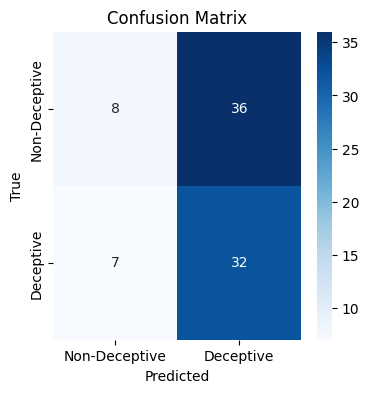

In [85]:
from transformers import AutoModelForAudioClassification
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline

## loading here as well to not lose time
dataset = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/deceptive-16khz", split='train')
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

first_indices = list(range(15))
last_indices = list(range(len(dataset['label']) - 15, len(dataset['label'])))
validation_indices = first_indices + last_indices
validation_dataset = dataset.select(validation_indices)


dataset = validation_dataset
dataset = apply_window(dataset)

model = AutoModelForAudioClassification.from_pretrained("/content/hubert_deception-1/checkpoint-1")
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
classifier = pipeline("audio-classification", model=model,feature_extractor = feature_extractor)

y_true_test = dataset["label"]
print(y_true_test)
predictions_test = []

for file in dataset:
    audio_array = np.array(file["audio"]['array'])
    sampling_rate = 16000

    result = classifier({"raw": audio_array, "sampling_rate": sampling_rate})
    predictions_test.append(result[0]["label"])

label_mapping = {"LABEL_0": 0, "LABEL_1": 1}
predictions_test = [label_mapping[label] for label in predictions_test]

print(predictions_test)
precision = precision_score(y_true_test, predictions_test)
recall = recall_score(y_true_test, predictions_test)
f1 = f1_score(y_true_test, predictions_test)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


cm_test = confusion_matrix(y_true_test, predictions_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Deceptive", "Deceptive"], yticklabels=["Non-Deceptive", "Deceptive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from transformers import pipeline

classifier = pipeline("audio-classification", model="/content/hubert_deception-1/checkpoint-80")
for file in dataset :
  audio = file["audio"]["path"]
  print(classifier(audio))

[{'score': 0.6854604482650757, 'label': 'LABEL_1'}, {'score': 0.3145395517349243, 'label': 'LABEL_0'}]
[{'score': 0.9022054672241211, 'label': 'LABEL_1'}, {'score': 0.09779457747936249, 'label': 'LABEL_0'}]
[{'score': 0.7441938519477844, 'label': 'LABEL_0'}, {'score': 0.25580617785453796, 'label': 'LABEL_1'}]
[{'score': 0.9032216668128967, 'label': 'LABEL_1'}, {'score': 0.09677833318710327, 'label': 'LABEL_0'}]
[{'score': 0.8836219310760498, 'label': 'LABEL_1'}, {'score': 0.11637815088033676, 'label': 'LABEL_0'}]
[{'score': 0.8940549492835999, 'label': 'LABEL_1'}, {'score': 0.10594508796930313, 'label': 'LABEL_0'}]
[{'score': 0.8764867782592773, 'label': 'LABEL_0'}, {'score': 0.12351320683956146, 'label': 'LABEL_1'}]
[{'score': 0.8802664279937744, 'label': 'LABEL_0'}, {'score': 0.11973357945680618, 'label': 'LABEL_1'}]
[{'score': 0.8819144368171692, 'label': 'LABEL_0'}, {'score': 0.11808554828166962, 'label': 'LABEL_1'}]
[{'score': 0.8738248944282532, 'label': 'LABEL_0'}, {'score': 0.1

# Train Model on Bag of Lies Dataset

### Generate Metadata

In [92]:
import pandas as pd
import re
import os
import csv

annot = pd.read_csv('/content/drive/MyDrive/bag-of-lies/BagOfLies/Annotations.csv')
annot[['video','truth']]
annot['video'] = annot['video'].str.replace("./Finalised/","")
annot['video'] = annot['video'].str.replace("/","_")
annot['video'] = annot['video'].str.replace("_video.mp4","")

def rearrange_string(input_str):
    parts = input_str.split('_')
    rearranged_str = f"{parts[2]}_{parts[3]}_{parts[0]}_{parts[1]}"
    return rearranged_str

for i in range(len(annot['video'])):
  annot['video'][i] = rearrange_string(annot['video'][i])


directory = "/content/drive/MyDrive/bag-of-lies/BagOfLies/Audio"
data = []
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        user_run = filename.replace(".wav", "")
        label = annot.copy().loc[annot['video'] == user_run]['truth'].reset_index()['truth'][0]
        if label == 1:
          label = 0
        else:
          label = 1
        data.append((filename, label))

csv_file_path = "/content/drive/MyDrive/bag-of-lies/BagOfLies/Audio/metadata.csv"


with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["file_name", "label"])
    writer.writerows(data)

print(f"Metadata file created at {csv_file_path}")



<ipython-input-92-28c6955affde>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['video'] = annot['video'].str.replace("./Finalised/","")
<ipython-input-92-28c6955affde>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['video'] = annot['video'].str.replace("_video.mp4","")
<ipython-input-92-28c6955affde>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annot['video'][i] = rearrange_string(annot['video'][i])


Metadata file created at /content/drive/MyDrive/bag-of-lies/BagOfLies/Audio/metadata.csv


### Training

In [90]:
from datasets import load_dataset
from datasets import Audio
from datasets import DatasetDict, Dataset
from transformers import AutoFeatureExtractor
import evaluate
import numpy as np
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score,confusion_matrix,precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from collections import defaultdict
from transformers import EarlyStoppingCallback

In [95]:
#read data
dataset = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/bag-of-lies/BagOfLies/Audio",split='train')
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
print(dataset)

first_indices = list(range(15))
last_indices = list(range(len(dataset['label']) - 15, len(dataset['label'])))
validation_indices = first_indices + last_indices
validation_dataset = dataset.select(validation_indices)

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
num_labels = 2
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_f1_scores = []

dataset = dataset.select([i for i in range(len(dataset)) if i not in validation_indices])

train_model(dataset)


Resolving data files:   0%|          | 0/326 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['audio', 'label'],
    num_rows: 325
})

----- Fold 1 -----
Dataset({
    features: ['audio', 'label'],
    num_rows: 236
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 59
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 212
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 60
})


Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight', 'projector.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
0,No log,0.683544,0.746922,0.666667,0.651429
1,0.686900,0.669123,0.698750,0.650000,0.641031
2,0.681600,0.656530,0.762931,0.583333,0.460970
4,0.656300,0.623260,0.639583,0.616667,0.613784
5,0.646000,0.619833,0.639583,0.616667,0.613784
6,0.646000,0.612309,0.639583,0.616667,0.613784
8,0.617700,0.615149,0.639583,0.616667,0.613784


Fold 1 - F1 Score: 0.6137844611528822

----- Fold 2 -----
Dataset({
    features: ['audio', 'label'],
    num_rows: 236
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 59
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 224
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 48
})


Map:   0%|          | 0/224 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight', 'projector.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
1,No log,0.691055,0.610482,0.520833,0.455147
2,0.690000,0.681494,0.657171,0.520833,0.435939
3,0.666500,0.677451,0.657171,0.520833,0.435939


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
1,No log,0.691055,0.610482,0.520833,0.455147
2,0.690000,0.681494,0.657171,0.520833,0.435939
3,0.666500,0.677451,0.657171,0.520833,0.435939
4,0.666500,0.687051,0.770833,0.541667,0.450000
5,0.642400,0.656374,0.505586,0.520833,0.494575
6,0.615700,0.663574,0.606481,0.562500,0.454789
7,0.615700,0.649293,0.770833,0.541667,0.450000
8,0.624700,0.658382,0.776163,0.562500,0.484988
9,0.612200,0.657582,0.584402,0.520833,0.471233
10,0.608200,0.651196,0.610482,0.520833,0.455147


Fold 2 - F1 Score: 0.45

----- Fold 3 -----
Dataset({
    features: ['audio', 'label'],
    num_rows: 236
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 59
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 214
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 58
})


Map:   0%|          | 0/214 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight', 'projector.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
0,No log,0.706864,0.131094,0.362069,0.192492
1,0.691800,0.717147,0.295856,0.310345,0.218913
2,0.665500,0.760093,0.448276,0.362069,0.220802
4,0.665500,0.751932,0.490177,0.465517,0.474582


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 - F1 Score: 0.1924923614142296

----- Fold 4 -----
Dataset({
    features: ['audio', 'label'],
    num_rows: 236
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 59
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 217
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 55
})


Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight', 'projector.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
1,No log,0.730817,0.055868,0.236364,0.090374
2,0.689600,0.794639,0.820539,0.254545,0.127241
3,0.669800,0.758371,0.838581,0.490909,0.495623
4,0.669800,0.695140,0.838581,0.490909,0.495623
5,0.649500,0.688144,0.838581,0.490909,0.495623
6,0.627200,0.732713,0.838581,0.490909,0.495623
7,0.627200,0.731247,0.838581,0.490909,0.495623
8,0.613800,0.666779,0.844498,0.545455,0.560561
9,0.611000,0.678171,0.844498,0.545455,0.560561
10,0.613600,0.697598,0.840455,0.509091,0.517866


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4 - F1 Score: 0.5605607420163752

----- Fold 5 -----
Dataset({
    features: ['audio', 'label'],
    num_rows: 236
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 59
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 221
})
Dataset({
    features: ['audio', 'label'],
    num_rows: 51
})


Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.weight', 'projector.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score
1,No log,0.684284,0.686275,0.686275,0.686275
2,0.691800,0.708561,0.169550,0.411765,0.240196
3,0.682800,0.685671,0.169550,0.411765,0.240196
4,0.682800,0.646910,0.615090,0.588235,0.590455
5,0.662800,0.618266,0.714869,0.705882,0.707946
6,0.647700,0.617927,0.780392,0.529412,0.458111
7,0.647700,0.573775,0.783720,0.784314,0.781153
8,0.631600,0.566056,0.764706,0.764706,0.759675
9,0.616400,0.563384,0.792756,0.784314,0.785827
10,0.653400,0.565257,0.792997,0.745098,0.745098


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5 - F1 Score: 0.7858273133814929

Mean F1 Score across all folds: 0.5205329755929959


Resolving data files:   0%|          | 0/326 [00:00<?, ?it/s]

Dataset({
    features: ['audio', 'label'],
    num_rows: 325
})
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0

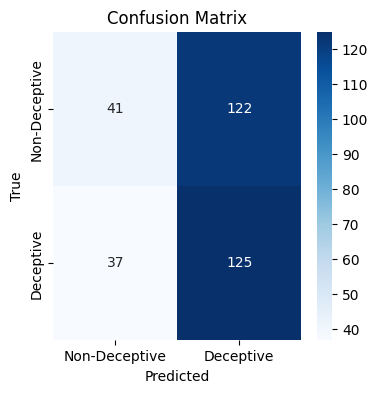

In [97]:
dataset = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/bag-of-lies/BagOfLies/Audio",split='train')
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
print(dataset)

first_indices = list(range(35))
last_indices = list(range(len(dataset['label']) - 35, len(dataset['label'])))
validation_indices = first_indices + last_indices
validation_dataset = dataset.select(validation_indices)

y_true_test = dataset["label"]
print(y_true_test)
predictions_test = []

for file in dataset:
    audio_array = np.array(file["audio"]['array'])
    sampling_rate = 16000

    result = classifier({"raw": audio_array, "sampling_rate": sampling_rate})
    predictions_test.append(result[0]["label"])

label_mapping = {"LABEL_0": 0, "LABEL_1": 1}
predictions_test = [label_mapping[label] for label in predictions_test]

print(predictions_test)
precision = precision_score(y_true_test, predictions_test)
recall = recall_score(y_true_test, predictions_test)
f1 = f1_score(y_true_test, predictions_test)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


cm_test = confusion_matrix(y_true_test, predictions_test)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Deceptive", "Deceptive"], yticklabels=["Non-Deceptive", "Deceptive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
"""
import pydub
def convert_video_to_wav(video_file, output_file):
    audio = pydub.AudioSegment.from_file(video_file, format="mp4")
    audio.export(output_file, format="wav")
    if os.path.exists(video_file):
      os.remove(video_file)
"""

"""
import os
def get_video_files(root_folder):
    video_files = []
    for user_folder in os.listdir(root_folder):
        user_path = os.path.join(root_folder, user_folder)
        for run_folder in os.listdir(user_path):
            run_path = os.path.join(user_path, run_folder)
            for filename in os.listdir(run_path):
                if filename.endswith(".mp4") :
                    video_file = os.path.join(run_path, filename)
                    video_files.append(video_file)
    return video_files
"""

In [ ]:
"""
for i, video_file in enumerate(video_files):
    user_folder = os.path.basename(os.path.dirname(video_file))
    run_number = os.path.basename(os.path.dirname(os.path.dirname(video_file)))
    filename, extension = os.path.splitext(os.path.basename(video_file))

    output_file = os.path.join("/content/drive/MyDrive/bag-of-lies/BagOfLies/Audio", f"{user_folder}_{run_number}.wav")
    convert_video_to_wav(video_file, output_file)

    print(f"Converted {video_file} to {output_file}")
"""

'\nfor i, video_file in enumerate(video_files):\n    user_folder = os.path.basename(os.path.dirname(video_file))\n    run_number = os.path.basename(os.path.dirname(os.path.dirname(video_file)))\n    filename, extension = os.path.splitext(os.path.basename(video_file))\n\n    output_file = os.path.join("/content/drive/MyDrive/bag-of-lies/BagOfLies/Audio", f"{user_folder}_{run_number}.wav")\n    convert_video_to_wav(video_file, output_file)\n\n    print(f"Converted {video_file} to {output_file}")\n'